# HW-05

#### Author: Sanjay Bhargav Siddi

This document shows a comprehensive regression analysis on a the Life Expectancy dataset from the 2023 #tidytuesday repository. The process includes data exploration, preprocessing, Ordinary Least Squares (OLS) regression with assumption checks, and the implementation and evaluation of alternative regression methods such as Random Forests and SVR.


## 1. Data selection and exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import statsmodels.api as sm
from sklearn.utils import resample
from sklearn.linear_model import Ridge, Lasso

warnings.filterwarnings("ignore")

Getting the dataset from #tidytuesday


In [2]:
life_expectancy = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-12-05/life_expectancy.csv')
life_expectancy_different_ages = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-12-05/life_expectancy_different_ages.csv')
life_expectancy_female_male = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2023/2023-12-05/life_expectancy_female_male.csv')

In [3]:
merged_data = pd.merge(life_expectancy, life_expectancy_different_ages, on=['Entity', 'Code', 'Year'])
data = pd.merge(merged_data, life_expectancy_female_male, on=['Entity', 'Code', 'Year'])

In [4]:
data

,Entity,Code,Year,LifeExpectancy,LifeExpectancy0,LifeExpectancy10,LifeExpectancy25,LifeExpectancy45,LifeExpectancy65,LifeExpectancy80,LifeExpectancyDiffFM
0,Afghanistan,AFG,1950,27.7275,27.7275,49.1459,54.442200,63.422500,73.4901,83.7259,1.261900
1,Afghanistan,AFG,1951,27.9634,27.9634,49.2941,54.564400,63.500603,73.5289,83.7448,1.270601
2,Afghanistan,AFG,1952,28.4456,28.4456,49.5822,54.799800,63.647600,73.6018,83.7796,1.288300
3,Afghanistan,AFG,1953,28.9304,28.9304,49.8634,55.028603,63.788902,73.6706,83.8118,1.306601
4,Afghanistan,AFG,1954,29.2258,29.2258,49.9306,55.116500,63.848100,73.7041,83.8334,1.276501
...,...,...,...,...,...,...,...,...,...,...,...
19485,Zimbabwe,ZWE,2017,60.7095,60.7095,64.6277,66.110596,71.014100,78.5895,86.8135,4.748299
19486,Zimbabwe,ZWE,2018,61.4141,61.4141,65.1821,66.604500,71.267200,78.6681,86.8399,4.625503
19487,Zimbabwe,ZWE,2019,61.2925,61.2925,65.0582,66.491600,71.203400,78.6739,86.8614,5.017799
19488,Zimbabwe,ZWE,2020,61.1242,61.1242,64.8006,66.086900,70.519104,78.0986,86.5717,5.732201


#### Dataset Description:

|     Variable           |   Class  |             Description                           |
|:-----------------------:|:--------:|:-------------------------------------------------:|
|         Entity          | character|     Country or region entity                       |
|          Code           | character|              Entity code                           |
|          Year           |  double  |                    Year                             |
|    LifeExpectancy0      |  double  | Period life expectancy at birth - Sex: all - Age: 0|
|    LifeExpectancy10     |  double  |    Period life expectancy - Sex: all - Age: 10    |
|    LifeExpectancy25     |  double  |    Period life expectancy - Sex: all - Age: 25    |
|    LifeExpectancy45     |  double  |    Period life expectancy - Sex: all - Age: 45    |
|    LifeExpectancy65     |  double  |    Period life expectancy - Sex: all - Age: 65    |
|    LifeExpectancy80     |  double  |    Period life expectancy - Sex: all - Age: 80    |
| LifeExpectancyDiffFM    |  double  | Life expectancy difference (f-m) - Type: period - Sex: both - Age: 0|


In [5]:
# Describe missing values
missing_values = data.isnull().sum()
missing_values

Entity                     0
Code                    1168
Year                       0
LifeExpectancy             0
LifeExpectancy0            0
LifeExpectancy10           0
LifeExpectancy25           0
LifeExpectancy45           0
LifeExpectancy65           0
LifeExpectancy80           0
LifeExpectancyDiffFM       0
dtype: int64

There are 1168 rows which have null values in the Code column. 

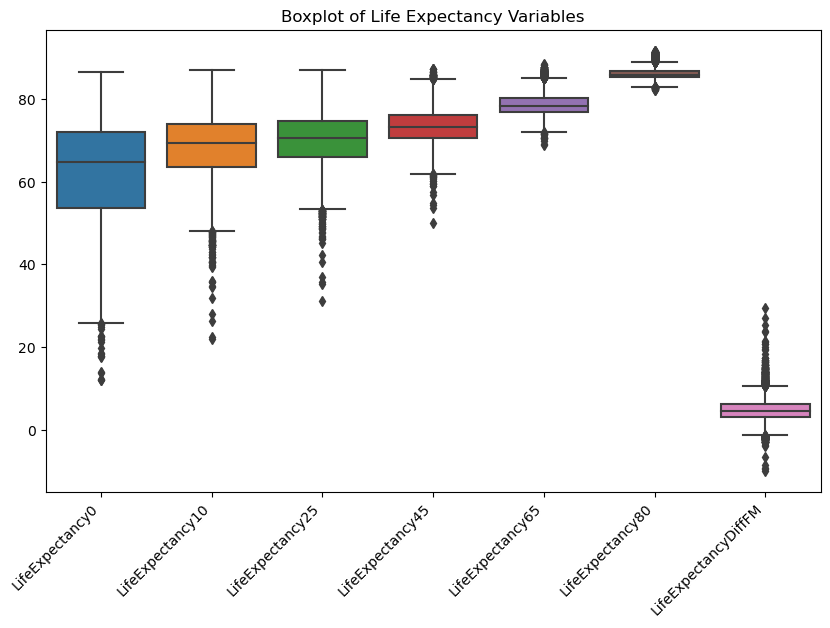

In [6]:
# Plot outliers
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=data[['LifeExpectancy0', 'LifeExpectancy10', 'LifeExpectancy25', 'LifeExpectancy45', 'LifeExpectancy65', 'LifeExpectancy80', 'LifeExpectancyDiffFM']])
plt.title('Boxplot of Life Expectancy Variables')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

From this box plot we can easily identify the outliers. We can observe the prensence of extreme values in the dataset by looking at the data points below the whiskers. 

Example 1: In LifeExpectancy0 and LifeExpectancy1, the median line is not in the center suggesting that the data is not symmetrically distributed. The tall box size of LifeExpectancy0 indicates the narrow spread of data in it. 

Example 2: In LifeExpectancy45, the outliers are present at either ends of the whiskers. And the wide nature of the box suggests a wider spread.

In [7]:
data_shape = data.shape
data_shape

(19490, 11)

In [8]:
correlation_matrix = merged_data.corr()
correlation_matrix

,Year,LifeExpectancy,LifeExpectancy0,LifeExpectancy10,LifeExpectancy25,LifeExpectancy45,LifeExpectancy65,LifeExpectancy80
Year,1.000000,0.597792,0.597792,0.537543,0.523513,0.521685,0.528763,0.495097
LifeExpectancy,0.597792,1.000000,1.000000,0.968572,0.953081,0.917104,0.876127,0.796174
LifeExpectancy0,0.597792,1.000000,1.000000,0.968572,0.953081,0.917104,0.876127,0.796174
LifeExpectancy10,0.537543,0.968572,0.968572,1.000000,0.996099,0.968553,0.919194,0.828120
LifeExpectancy25,0.523513,0.953081,0.953081,0.996099,1.000000,0.983986,0.937024,0.844521
LifeExpectancy45,0.521685,0.917104,0.917104,0.968553,0.983986,1.000000,0.977651,0.898823
LifeExpectancy65,0.528763,0.876127,0.876127,0.919194,0.937024,0.977651,1.000000,0.961757
LifeExpectancy80,0.495097,0.796174,0.796174,0.828120,0.844521,0.898823,0.961757,1.000000


The correlation between the "Year" variable and "Life Expectancy" is 0.60, indicating a moderate positive correlation.

All variables related to life expectancy show strong positive correlations with each other, ranging from 0.80 to 1.00

There is a decreasing trend in the correlation as the age groups get farther apart. For example, "LifeExpectancy" and "LifeExpectancy80" have a lower correlation (0.50), indicating a weaker positive relationship compared to the correlations within closer age groups

--------------------------------------------------------------------------------------------------------------------------------

## 2. Data Preprocessing

In [9]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)

cleaned_data = data[~outliers]

In [10]:
cleaned_data

,Entity,Code,Year,LifeExpectancy,LifeExpectancy0,LifeExpectancy10,LifeExpectancy25,LifeExpectancy45,LifeExpectancy65,LifeExpectancy80,LifeExpectancyDiffFM
0,Afghanistan,AFG,1950,27.7275,27.7275,49.1459,54.442200,63.422500,73.4901,83.7259,1.261900
1,Afghanistan,AFG,1951,27.9634,27.9634,49.2941,54.564400,63.500603,73.5289,83.7448,1.270601
2,Afghanistan,AFG,1952,28.4456,28.4456,49.5822,54.799800,63.647600,73.6018,83.7796,1.288300
3,Afghanistan,AFG,1953,28.9304,28.9304,49.8634,55.028603,63.788902,73.6706,83.8118,1.306601
4,Afghanistan,AFG,1954,29.2258,29.2258,49.9306,55.116500,63.848100,73.7041,83.8334,1.276501
...,...,...,...,...,...,...,...,...,...,...,...
19485,Zimbabwe,ZWE,2017,60.7095,60.7095,64.6277,66.110596,71.014100,78.5895,86.8135,4.748299
19486,Zimbabwe,ZWE,2018,61.4141,61.4141,65.1821,66.604500,71.267200,78.6681,86.8399,4.625503
19487,Zimbabwe,ZWE,2019,61.2925,61.2925,65.0582,66.491600,71.203400,78.6739,86.8614,5.017799
19488,Zimbabwe,ZWE,2020,61.1242,61.1242,64.8006,66.086900,70.519104,78.0986,86.5717,5.732201


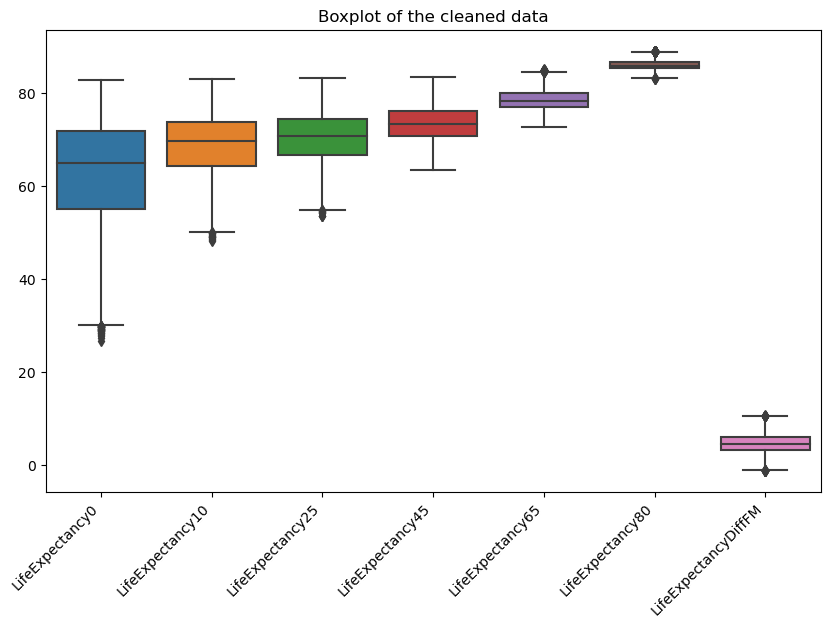

In [11]:
# Plot outliers
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=cleaned_data[['LifeExpectancy0', 'LifeExpectancy10', 'LifeExpectancy25', 'LifeExpectancy45', 'LifeExpectancy65', 'LifeExpectancy80', 'LifeExpectancyDiffFM']])
plt.title('Boxplot of the cleaned data')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [12]:
df = cleaned_data
#f = df[['Year', 'Entity', 'LifeExpectancy']]

### Label Encoding: Transform categorical values into numerical labels

In [13]:
label_encoder = LabelEncoder()
# Applying label encoding to "Entity" column
df['Entity'] = label_encoder.fit_transform(df['Entity'])

## 3. Ordinary Least Squares (OLS) Regression

### Can we predict life expectancy at age 45 based on the selected features?

In [14]:
X = df.drop(['LifeExpectancy','LifeExpectancy0','Code','LifeExpectancyDiffFM'], axis=1)  # Features
y = df['LifeExpectancy0']  # Target variable

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Resampling 
X_train_resampled, y_train_resampled = resample(X_train, y_train, replace=True, random_state=42)

In [16]:
# Model Building with statsmodels
X_train_sm = sm.add_constant(X_train_resampled)  

# Adding a constant for the intercept
ols_model = sm.OLS(y_train_resampled, X_train_sm).fit()

# Evaluating the Model Performance
# Adding a constant for the intercept in test data (statsmodels)
X_test_sm = sm.add_constant(X_test) 

# Predicting using statsmodels model
y_pred_sm = ols_model.predict(X_test_sm)

# Model Diagnostics
ols_model.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LifeExpectancy0   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 5.673e+04
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:20:00   Log-Likelihood:                -30292.
No. Observations:               13949   AIC:                         6.060e+04
Df Residuals:                   13941   BIC:                         6.066e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -63.6313      3.410    -18.661      0.000     -70.315     -56.948
Entity               0.0001      0.000      0.508      0.611      -0.000       0.001
Year                 0.0166      0.001     17.568      0.000       0.015       0.018
LifeExpectancy10     5.6042      0.066     84.448      0.000       5.474       5.734
LifeExpectancy25    -5.4611      0.126    -43.312      0.000      -5.708      -5.214
LifeExpectancy45     1.1135      0.120      9.315      0.000       0.879       1.348
LifeExpectancy65    -0.0165      0.116     -0.143      0.886      -0.243       0.210
LifeExpectancy80     0.1356      0.081      1.667      0.095      -0.024       0.295
==============================================================================
Omnibus:                     2140.528   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20844.814
Skew:                          -0.432   Prob(JB):                         0.00
Kurtosis:                       8.926   Cond. No.                     3.78e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

R-squared value is 96.6%

This suggests a good fit and indicates that approximately 96.6% of the variance in the dependent variable (LifeExpectancy0) is explained by the independent variables in the model

The p-values indicate the statistical significance of each predictor. A small p-value suggests that the variable is likely a meaningful addition to the model. The significant coefficients with low p-values suggest that 'Year,' 'LifeExpectancy10,' 'LifeExpectancy25,' 'LifeExpectancy45' are likely important predictors of 'LifeExpectancy0.

The high condition number suggests potential multicollinearity, indicating that some predictors might be highly correlated

In [17]:
residuals = y_test - y_pred_sm
dw_test = sm.stats.stattools.durbin_watson(residuals)
print(f"Durbin-Watson test statistic: {dw_test}")

Durbin-Watson test statistic: 1.97398253794617


There is little evidence of significant autocorrelation in the residuals, but since it is within the 1.5 to 2.5 range we can say there is no significant autocorrelation.

### OLS Regression with CV

In [18]:
# 5 Folds
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

# Lists to store evaluation metrics across folds
r_squared_values = []
mae_values = []

for train_index, val_index in kf.split(X_train_resampled):
    # Splitting data into train and validation sets for this fold
    X_train_fold, X_val_fold = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
    y_train_fold, y_val_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]

    # Fitting the OLS model
    ols_model_fold = sm.OLS(y_train_fold, sm.add_constant(X_train_fold)).fit()

    # Making predictions on the validation set
    y_pred_val = ols_model_fold.predict(sm.add_constant(X_val_fold))

    # Calculating R-squared for this fold
    r_squared_fold = 1 - (np.sum((y_val_fold - y_pred_val) ** 2) / np.sum((y_val_fold - np.mean(y_val_fold)) ** 2))
    r_squared_values.append(r_squared_fold)

    # Calculating MAE for this fold
    mae_fold = np.mean(np.abs(y_val_fold - y_pred_val))
    mae_values.append(mae_fold)

# Calculating average metrics across all folds
avg_r_squared = np.mean(r_squared_values)
avg_mae = np.mean(mae_values)

# Printing average metrics
print("Average R-squared across folds:", avg_r_squared)
print("Average MAE across folds:", avg_mae)

Average R-squared across folds: 0.9659915752082947
Average MAE across folds: 1.4288174488293415


In [19]:
ols_model_fold.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        LifeExpectancy0   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 4.472e+04
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:20:00   Log-Likelihood:                -24225.
No. Observations:               11160   AIC:                         4.847e+04
Df Residuals:                   11152   BIC:                         4.852e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -66.6259      3.795    -17.558      0.000     -74.064     -59.188
Entity            4.551e-05      0.000      0.165      0.869      -0.000       0.001
Year                 0.0166      0.001     15.784      0.000       0.015       0.019
LifeExpectancy10     5.5720      0.073     76.052      0.000       5.428       5.716
LifeExpectancy25    -5.4118      0.139    -39.028      0.000      -5.684      -5.140
LifeExpectancy45     1.1146      0.132      8.472      0.000       0.857       1.373
LifeExpectancy65    -0.0704      0.128     -0.548      0.584      -0.322       0.181
LifeExpectancy80     0.2046      0.091      2.260      0.024       0.027       0.382
==============================================================================
Omnibus:                     1711.010   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17347.023
Skew:                          -0.414   Prob(JB):                         0.00
Kurtosis:                       9.051   Cond. No.                     3.77e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Comparing:

Both models have high R-squared values, suggesting a good fit to the data. Model 1 has more observations and a higher F-statistic, but Model 2 has a lower AIC, indicating a more economical model. The differences in coefficients are expected due to the different subsets of data used in training and testing.

## 4. Other Regression Techniques

Scaling the dataset

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Ridge Regression

Ridge Regression is a linear regression technique that addresses the issue of multicollinearity in multiple linear regression. Multicollinearity occurs when independent variables in a regression model are highly correlated, leading to instability and inflated standard errors in parameter estimates.

Ridge Regression is widely used in machine learning and statistics to improve the stability and reliability of linear regression models, particularly when dealing with high-dimensional datasets or correlated predictors

In [21]:
ridge_params = {'alpha': [0.1, 1.0, 5.0, 10.0]}
ridge_model = Ridge()
ridge_grid = GridSearchCV(ridge_model, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1.0, 5.0, 10.0]},
             scoring='neg_mean_squared_error')

In [22]:
# Evaluating Ridge Regression
ridge_predictions = ridge_grid.predict(X_test_scaled)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
print(f'Ridge Regression Mean Squared Error: {ridge_mse}')
print("Best Ridge Hyperparameters:", ridge_grid.best_params_)

Ridge Regression Mean Squared Error: 4.716492458393628
Best Ridge Hyperparameters: {'alpha': 0.1}


### Lasso Regression

Lasso Regression is a linear regression technique used for variable selection and regularization. Similar to Ridge Regression, Lasso Regression aims to prevent overfitting and improve model interpretability by adding a penalty term to the ordinary least squares objective function.

In [23]:
lasso_params = {'alpha': [0.1, 1.0, 5.0, 10.0]}
lasso_model = Lasso()
lasso_grid = GridSearchCV(lasso_model, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.1, 1.0, 5.0, 10.0]},
             scoring='neg_mean_squared_error')

In [24]:
# Evaluating Lasso Regression
lasso_predictions = lasso_grid.predict(X_test_scaled)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
print(f'Lasso Regression Mean Squared Error: {lasso_mse}')
print("Best Lasso Hyperparameters:", lasso_grid.best_params_)

Lasso Regression Mean Squared Error: 6.8459625667892885
Best Lasso Hyperparameters: {'alpha': 0.1}


In [25]:
# Interpretation of sparse coefficients in Lasso Regression
lasso_coefficients = lasso_grid.best_estimator_.coef_
print("\nLasso Regression Coefficients:")
for feature, coefficient in zip(X.columns, lasso_coefficients):
    print(f'{feature}: {coefficient}')


Lasso Regression Coefficients:
Entity: 0.04470436408778068
Year: 0.6219651203781972
LifeExpectancy10: 12.278419476747326
LifeExpectancy25: -0.0
LifeExpectancy45: -1.9369881134869404
LifeExpectancy65: -0.0
LifeExpectancy80: 0.2925450119403004


Entity, Year, LifeExpectancy10, and LifeExpectancy80 -
The coefficients for these variables are positive, indicating that as the values increase, the predicted 'LifeExpectancy0' also increases.

LifeExpectancy25, LifeExpectancy65: 0.0 -
The coefficients for 'LifeExpectancy25', and 'LifeExpectancy65' are zero, implying that these variables doe not contribute to the prediction of 'LifeExpectancy0' in the model.

LifeExpectancy45: -1.9370 -
The 'LifeExpectancy45' variable has a negative coefficient, suggesting a negative impact on the predicted 'LifeExpectancy0'.

### Conclusion:

In terms of model performance, the OLS model has the lowest average MAE across folds, indicating better predictive accuracy compared to both Lasso and Ridge Regression.
Ridge Regression has a lower Mean Squared Error (4.716) compared to Lasso Regression (6.846). This suggests that Ridge Regression is performing better in terms of overall prediction accuracy on the test data.

In terms of feature selection, lasso Regression tends to set some coefficients to exactly zero, leading to sparsity in the model. The zero coefficients imply that certain features are not contributing significantly to the predictions.

In summary, based on the provided results, OLS performs well in terms of prediction accuracy, while Ridge Regression outperforms Lasso Regression in terms of Mean Squared Error.